<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/MY_BAKA_CHAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FONT

In [ ]:
def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '24px'
      break
    }
  }
  '''))
get_ipython().events.register('pre_run_cell', increase_font)

# MODELING

In [ ]:
!pip install catboost
!pip install -U pandas

<IPython.core.display.Javascript object>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
project_dir = 'drive/My Drive/nwds-k-benchmark'
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier,GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import log_loss

<IPython.core.display.Javascript object>

In [ ]:
train = pd.read_csv(f'{project_dir}/train.csv')
train.shape

<IPython.core.display.Javascript object>

(666512, 29)

In [ ]:
train.columns.values

<IPython.core.display.Javascript object>

array(['index', 'pitch_type', 'pitch_name', 'on_3b', 'on_2b', 'on_1b',
       'inning', 'inning_topbot', 'outs_when_up', 'balls', 'strikes',
       'n_thruorder_pitcher', 'stand', 'p_throws', 'sz_top', 'sz_bot',
       'pfx_x', 'pfx_z', 'arm_angle', 'release_speed', 'release_pos_x',
       'release_extension', 'release_pos_z', 'release_spin_rate',
       'spin_axis', 'bat_speed', 'swing_length', 'is_strike', 'k'],
      dtype=object)

<IPython.core.display.Javascript object>

,pfx_x
count,666512.000000
mean,-0.102157
std,0.898520
min,-2.950000
25%,-0.880000
50%,-0.160000
75%,0.620000
max,2.400000


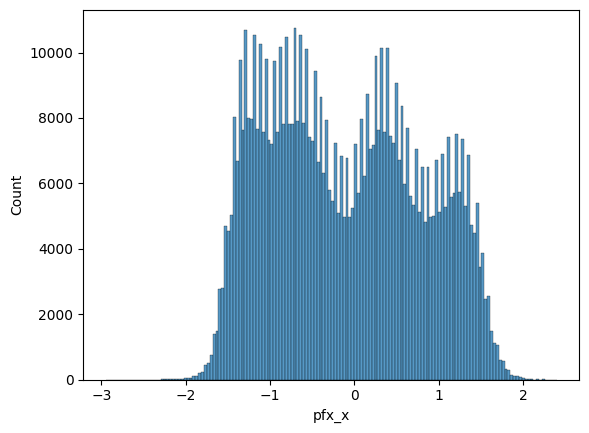

In [ ]:
sns.histplot(train['pfx_x'])
train['pfx_x'].describe()

<IPython.core.display.Javascript object>

<Axes: xlabel='pfx_x', ylabel='Count'>

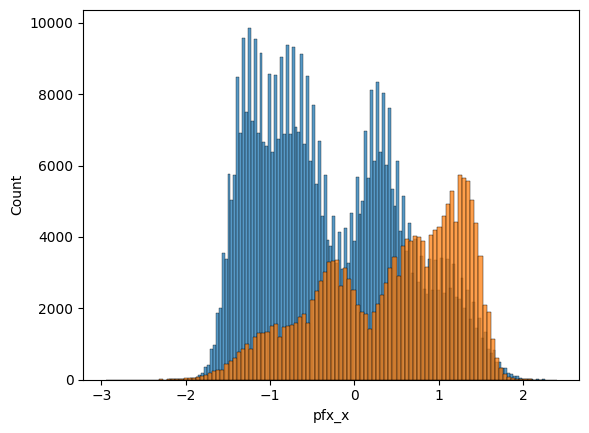

In [ ]:
sns.histplot(train.loc[train['p_throws']=='R','pfx_x'])
sns.histplot(train.loc[train['p_throws']=='L','pfx_x'])

In [ ]:
kiegh_: did you do the weird dot butthole game yet?

#weird.butthole

In [ ]:
a = 'aadvark'
b = 'nuts'

c = [a, b]
for d in c:
  # print(f'deez {d}!')
  print('deez ' + d + '?')


<IPython.core.display.Javascript object>

deez aadvark?
deez nuts?


In [ ]:
cols = ['pfx_x', 'release_pos_x']
for col in cols:
  train[f'{col}_adj'] = train[col].copy()
  train.loc[train['p_throws']=='L', f'{col}_adj'] = train.loc[train['p_throws']=='L', f'{col}_adj'].mul(-1)

train['spin_axis_adj'] = train['spin_axis'].copy()
train.loc[train['p_throws']=='L', 'spin_axis_adj'] = train.loc[train['p_throws']=='L', 'spin_axis_adj'].mul(-1).add(360)
train['spin_axis_adj'] = train['spin_axis_adj'].replace(360,0)

train['pitch_type_code'] = train['pitch_type'].astype('category').cat.codes
train['is_lhb'] = 0
train.loc[train['stand']=='L', 'is_lhb'] = 1

train['is_lhp'] = 0
train.loc[train['p_throws']=='L', 'is_lhp'] = 1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,arm_angle
count,666512.000000
mean,38.108794
std,13.083229
min,-71.200000
25%,30.500000
50%,39.300000
75%,46.500000
max,128.600000


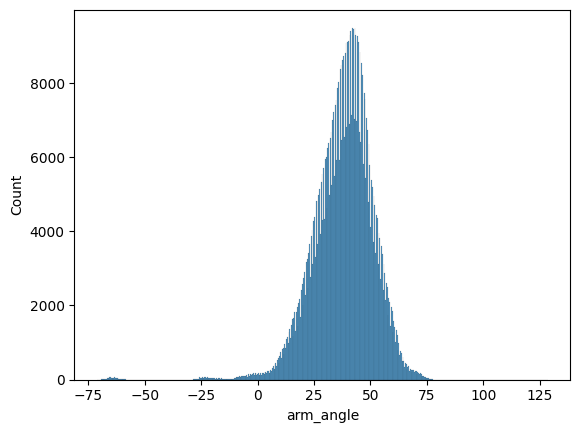

In [ ]:
sns.histplot(train['arm_angle'])
train['arm_angle'].describe()

In [ ]:
train.columns.values

<IPython.core.display.Javascript object>

array(['index', 'pitch_type', 'pitch_name', 'on_3b', 'on_2b', 'on_1b',
       'inning', 'inning_topbot', 'outs_when_up', 'balls', 'strikes',
       'n_thruorder_pitcher', 'stand', 'p_throws', 'sz_top', 'sz_bot',
       'pfx_x', 'pfx_z', 'arm_angle', 'release_speed', 'release_pos_x',
       'release_extension', 'release_pos_z', 'release_spin_rate',
       'spin_axis', 'bat_speed', 'swing_length', 'is_strike', 'k',
       'spin_axis_adj', 'pfx_x_adj', 'release_pos_x_adj',
       'pitch_type_code', 'is_lhb', 'is_lhp'], dtype=object)

In [ ]:
feats = [
    'inning','n_thruorder_pitcher','outs_when_up','balls',
    'strikes','sz_top', 'sz_bot','pfx_x', 'pfx_z', 'arm_angle',
    'release_speed', 'release_pos_x', 'release_extension',
    'release_pos_z', 'release_spin_rate', 'spin_axis_adj',
    'pfx_x_adj', 'release_pos_x_adj', 'pitch_type_code',
    'is_lhb', 'is_lhp'
]
target = 'is_strike'

<IPython.core.display.Javascript object>

In [ ]:
train.head()

<IPython.core.display.Javascript object>

,index,pitch_type,pitch_name,on_3b,on_2b,on_1b,inning,inning_topbot,outs_when_up,balls,strikes,n_thruorder_pitcher,stand,p_throws,sz_top,sz_bot,pfx_x,pfx_z,arm_angle,release_speed,release_pos_x,release_extension,release_pos_z,release_spin_rate,spin_axis,bat_speed,swing_length,is_strike,k,spin_axis_adj,pfx_x_adj,release_pos_x_adj,pitch_type_code,is_lhb,is_lhp
0,0,SL,Slider,False,True,False,8,Top,0,0,2,1,R,R,3.08,1.28,0.18,0.39,43.7,92.0,-2.77,6.2,6.50,2461.0,183.0,NaN,NaN,0,0,183.0,0.18,-2.77,14,0,0
1,1,FF,4-Seam Fastball,False,True,False,4,Top,2,3,2,2,R,L,3.44,1.65,0.63,1.53,57.9,96.1,1.90,6.8,6.71,2452.0,158.0,65.6,6.1,0,0,202.0,-0.63,-1.90,6,0,1
2,2,SL,Slider,False,False,False,7,Top,1,1,2,1,R,R,3.38,1.61,0.61,0.13,19.8,87.7,-1.84,5.9,5.14,2883.0,46.0,NaN,NaN,0,0,46.0,0.61,-1.84,14,0,0
3,3,SL,Slider,True,False,True,2,Bot,2,0,0,1,L,R,3.54,1.68,0.15,0.67,42.1,87.0,-1.22,6.4,5.50,2257.0,176.0,NaN,NaN,0,0,176.0,0.15,-1.22,14,1,0
4,4,SI,Sinker,False,True,True,7,Top,2,0,0,1,R,L,3.63,1.73,0.99,0.12,23.8,93.0,1.81,6.5,5.39,2229.0,129.0,NaN,NaN,0,0,231.0,-0.99,-1.81,13,0,1


In [ ]:
model_data = train.dropna(subset=feats+[target])
folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = HistGradientBoostingClassifier()
  model.fit(train_data.loc[:, feats], train_data[target])
  pred = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  s = pd.concat([s, pred])

model_data[f'{target}_sk'] = s

<IPython.core.display.Javascript object>

<ipython-input-9-b95b8219ccd5>:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s, pred])


In [ ]:
model_data.head()

<IPython.core.display.Javascript object>

,index,pitch_type,pitch_name,on_3b,on_2b,on_1b,inning,inning_topbot,outs_when_up,balls,...,swing_length,is_strike,k,pfx_x_adj,release_pos_x_adj,spin_axis_adj,pitch_type_code,is_lhb,is_lhp,is_strike_sk
0,0,SL,Slider,False,True,False,8,Top,0,0,...,NaN,0,0,0.18,-2.77,183.0,14,0,0,0.184906
1,1,FF,4-Seam Fastball,False,True,False,4,Top,2,3,...,6.1,0,0,-0.63,-1.90,202.0,6,0,1,0.558086
2,2,SL,Slider,False,False,False,7,Top,1,1,...,NaN,0,0,0.61,-1.84,46.0,14,0,0,0.459188
3,3,SL,Slider,True,False,True,2,Bot,2,0,...,NaN,0,0,0.15,-1.22,176.0,14,1,0,0.501596
4,4,SI,Sinker,False,True,True,7,Top,2,0,...,NaN,0,0,-0.99,-1.81,231.0,13,0,1,0.511804


In [ ]:
model_data = train.dropna(subset=feats+[target])
folds = 3
kf = KFold(folds, shuffle=True)
s = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = cb.CatBoostClassifier(verbose=False)
  model.fit(train_data.loc[:, feats], train_data[target])
  pred = pd.DataFrame(model.predict_proba(test_data.loc[:, feats]), index=test_data.index)[1]
  s = pd.concat([s, pred])

model_data[f'{target}_cb'] = s

<IPython.core.display.Javascript object>

<ipython-input-11-a457b01f16f3>:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s, pred])
